In [ ]:
pip install streamlit

['2.png', '1.png']


/var/folders/s5/y8d9ljs52g7bqbgnrq59ltv40000gn/T/ipykernel_14031/1193627601.py:146: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


---
{'agent': {'agent_outcome': AgentActionMessageLog(tool='get_image_analysis', tool_input={'prompt': 'Please analyze the images related to the product to identify key details such as product type, condition, brand, color, size, material, and overall image quality.'}, log="\nInvoking: `get_image_analysis` with `{'prompt': 'Please analyze the images related to the product to identify key details such as product type, condition, brand, color, size, material, and overall image quality.'}`\nresponded: To create an accurate description of the product, I'll start by analyzing the images. I'll use the available tool to get insights into the images. Let's begin by asking for the details of the images.\n\n", message_log=[AIMessage(content="To create an accurate description of the product, I'll start by analyzing the images. I'll use the available tool to get insights into the images. Let's begin by asking for the details of the images.", additional_kwargs={'function_call': {'arguments': '{"pro
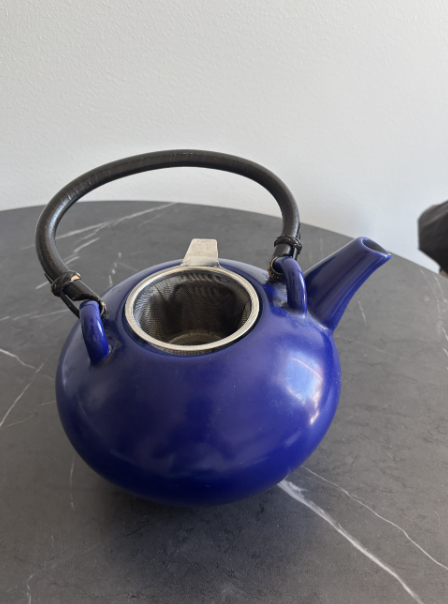
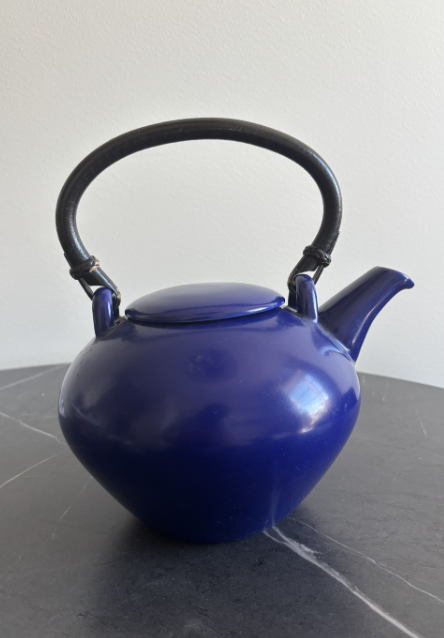
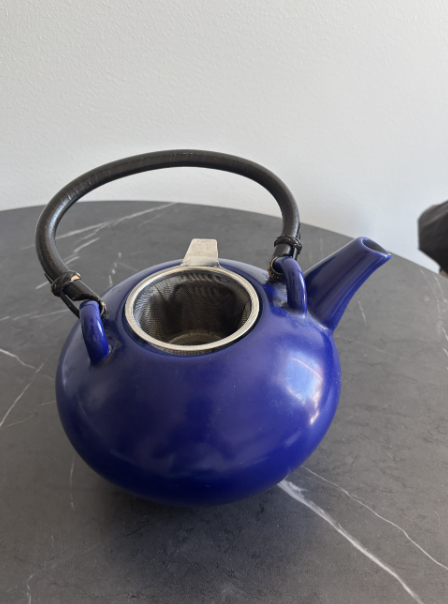
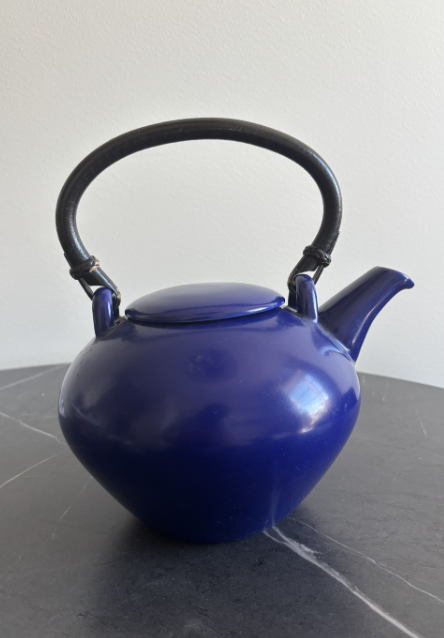
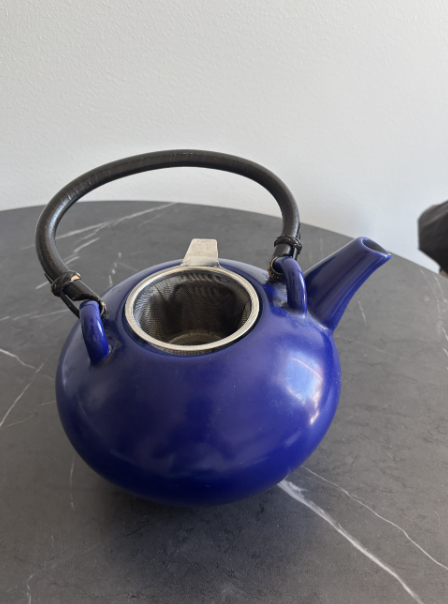
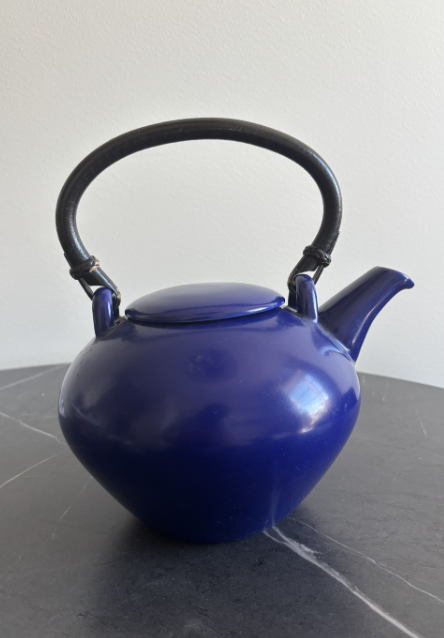

In [ ]:
import getpass
import os
import dotenv
from typing import TypedDict, Annotated, List, Union
import operator
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langchain_openai import ChatOpenAI

from langchain_community.chat_models import ChatOllama
from src.utils.image_processing import encode_image
dotenv.load_dotenv()

def get_llm(type, **kwargs):
    if type == "azure":
        if "AZURE_OPENAI_API_KEY" not in os.environ:
            os.environ["AZURE_OPENAI_API_KEY"] = getpass.getpass(
                "Enter your AzureOpenAI API key: "
            )
        return AzureChatOpenAI(
            azure_deployment=kwargs.get("azure_deployment", "gpt-4o"),
            api_version=kwargs.get("api_version", "2023-06-01-preview"),
            temperature=kwargs.get("temperature", 0),
            max_tokens=kwargs.get("max_tokens", None),
            timeout=kwargs.get("timeout", None),
            max_retries=5,
            **kwargs
        )
    elif type == "openai":
        return ChatOpenAI(
            api_key=os.getenv("OPENAI_API_KEY"),
            model=kwargs.get("model", "gpt-4o"),
            **kwargs
        )
    elif type == "ollama":
        # llm = ChatOllama(model="llama3.2")  # other models include
        # llama3.1:8b
        # llama3.2
        # llama3.1:70b
        # fore more see: https://ollama.com/library
        return ChatOllama(**kwargs)
    else:
        raise ValueError("Invalid LLM type")


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

# Tools

# Workflow functions
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

def execute_tools(data):
    agent_action = data["agent_outcome"]
    output = tool_executor.invoke(agent_action)
    return {"intermediate_steps": [(agent_action, str(output))]}

def should_continue(data):

    if isinstance(data["agent_outcome"], AgentFinish):
        return "end"
    else:
        return "continue"

def get_image_contents(uploaded_files):
    image_contents = []

    # Convert each uploaded image to base64 string
    for uploaded_file in uploaded_files:
        image_base64 = encode_image(uploaded_file)
        image_contents.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{image_base64}"}
        })

    return image_contents

def notebook_file_uploader():
    # product = 'bluetooth_sound_reciever_small'
    product = 'tea_pot_small'
    base_path = 'assets/trial_products'
    image_files = [f for f in os.listdir(f'{base_path}/{product}/') if f.endswith(('.png', '.jpg', '.jpeg'))]
    print(image_files)
    images = [Image.open(f'{base_path}/{product}/{file}') for file in image_files]
    return image_files, images, None


uploaded_files, images, _ = notebook_file_uploader()
image_contents = get_image_contents(images)
model = ChatOpenAI(model='gpt-4o', api_key=os.getenv("OPENAI_API_KEY"))
# print(image_contents)

# assert False

def multi_modal_prompt(prompt):
    """
    Makes a multimodal prompt with text and images
    """
    # Create the HumanMessage content
    message_content = [
        {"type": "text", "text": prompt}
    ] + image_contents

    return message_content


def get_image_analysis(prompt):
    """
    Prompt-guided image analysis. Supply a prompt and get the analysis of the image. This function gets the images by itself. All you have to do is provide the prompt. And you recieve a string with the analysis of the image.
    """
    message_content = multi_modal_prompt(prompt)

    # Create the message
    message = HumanMessage(content=message_content)

    # Invoke the model with the message
    return model.invoke([message])

def openai_api(text, prompt):
    model = ChatOpenAI(model='gpt-4o', api_key=os.getenv("OPENAI_API_KEY"))

    message_content = [
        {"type": "text", "text": prompt},
        {"type": "text", "text": text}
    ]

    # Create the message
    message = HumanMessage(content=message_content)

    return model.invoke([message])

llm = get_llm("openai")
# make workflow
if __name__ == "__main__":
    tools = [get_image_analysis]

    prompt = hub.pull("hwchase17/openai-functions-agent")

    agent_runnable = create_openai_functions_agent(llm, tools, prompt)

    tool_executor = ToolExecutor(tools)

    workflow = StateGraph(AgentState)

    workflow.add_node("agent", run_agent)
    workflow.add_node("action", execute_tools)

    workflow.set_entry_point("agent")

    workflow.add_conditional_edges(
        "agent", should_continue, {"continue": "action", "end": END}
    )
    
    # add node to extract description json

    workflow.add_edge("action", "agent")



    app = workflow.compile()

    inputs = {
        "input": """
                You are an AI assistant that helps users to create a description for their products to sell on facebook marketplace. Your colleague has some images. You can ask him for details about the images, you decide to ask him for details about the images.

                You will need to create a description of the product in the format of a json with the following format:    {'title': 'string', 'description': 'string', 'category': 'string', 'price': 'number', 'currency': 'string', 'condition': 'string', 'location': 'string', 'brand': 'string', 'model': 'string', 'color': 'string', 'size': 'string', 'material': 'string'}    If there is any information missing, you put 'unknown', but feel free to fill in with your best guess." 
                
                Use the available tools to help you with the task.

                Also, consider if more images are needed, or whether some images should be discarded.

                At the very end, make sure to return only the three following things:
                - json description of the product
                - json images, whether they are poor, meduim, or high quality, and whether they should be discarded
                - a question for the user to answer about the product if needed
                    """
    }

    for s in app.stream(inputs):
        print("---")
        print(s)

    openai_api("This is a test", "This is a test")




In [49]:
s['agent']['agent_outcome'].dict()['return_values']['output'].split('\n\n')

["Based on the analysis of the images, here's the product description and image quality assessment:",
 '### Product Description\n```json\n{\n  "title": "Medium Dark Blue Ceramic Teapot with Metal Infuser",\n  "description": "This medium-sized teapot is perfect for tea enthusiasts. Made from high-quality ceramic or porcelain, it comes in a stylish dark blue color. The teapot features a metal handle and an infuser, making it both functional and modern. Ideal for brewing your favorite teas, it is in good condition with no visible damage.",\n  "category": "Home & Kitchen",\n  "price": "unknown",\n  "currency": "unknown",\n  "condition": "good",\n  "location": "unknown",\n  "brand": "unknown",\n  "model": "unknown",\n  "color": "Dark Blue",\n  "size": "Medium",\n  "material": "Ceramic or Porcelain"\n}\n```',
 '### Image Quality\n```json\n{\n  "quality": "high",\n  "discard": false,\n  "note": "The images are clear and well-lit, showing the teapot from different angles."\n}\n```',
 '### Ques

In [ ]:
def openai_api(text, prompt):
    model = ChatOpenAI(model='gpt-4o', api_key=os.getenv("OPENAI_API_KEY"))

    message_content = [
        {"type": "text", "text": prompt},
        {"type": "text", "text": text}
    ]

    # Create the message
    message = HumanMessage(content=message_content)

    return model.invoke([message])


# Product description json
desc_json_raw = openai_api(s['agent']['agent_outcome'].dict()['return_values']['output'],
           'extract the description json. Only return the json.')

# Image Quality json
img_quality_json_raw = openai_api(s['agent']['agent_outcome'].dict()['return_values']['output'],
           'extract the image quality json. Only return the json.')

# Question for user
question = openai_api(s['agent']['agent_outcome'].dict()['return_values']['output'],
           'extract the question for the user. Only return the question.')




In [59]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

from config import OPENAI_API_KEY, MODEL_NAME
from src.utils.image_processing import encode_image

# Define your desired data structure.
class Suggestion(BaseModel):
    index: int = Field(description="index of the image")
    suggested_name: str = Field(description="suggested name for the image")
    keep_or_rid: str = Field(description="whether to keep or remove the image")

class imageQuality(BaseModel):
    quality: str = Field(description="quality of the image")
    discard: bool = Field(description="whether to discard the image")
    note: str = Field(description="note about the image")

class Final_report(BaseModel):
    title: str = Field(description="title of the product")
    description: str = Field(description="description of the product")
    category: str = Field(description="category of the product")
    price: float = Field(description="price of the product")
    currency: str = Field(description="currency of the product")
    condition: str = Field(description="condition of the product")
    location: str = Field(description="location of the product")
    brand: str = Field(description="brand of the product")
    model: str = Field(description="model of the product")

desc_json_parser = JsonOutputParser(pydantic_object=Final_report)
desc_json = desc_json_parser.parse(desc_json_raw.content)
print(desc_json)

img_quality_json_parser = JsonOutputParser(pydantic_object=imageQuality)
img_quality_json = img_quality_json_parser.parse(img_quality_json_raw.content)
print(img_quality_json)


print(question.content)

{'title': 'Medium Dark Blue Ceramic Teapot with Metal Infuser', 'description': 'This medium-sized teapot is perfect for tea enthusiasts. Made from high-quality ceramic or porcelain, it comes in a stylish dark blue color. The teapot features a metal handle and an infuser, making it both functional and modern. Ideal for brewing your favorite teas, it is in good condition with no visible damage.', 'category': 'Home & Kitchen', 'price': 'unknown', 'currency': 'unknown', 'condition': 'good', 'location': 'unknown', 'brand': 'unknown', 'model': 'unknown', 'color': 'Dark Blue', 'size': 'Medium', 'material': 'Ceramic or Porcelain'}
{'quality': 'high', 'discard': False, 'note': 'The images are clear and well-lit, showing the teapot from different angles.'}
What is the price you would like to set for this teapot, and in which currency? Additionally, do you have the brand or model information?


'What is the price you would like to set for this teapot, and in which currency? Additionally, do you have the brand or model information?'